In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from Finite_volume_method_1D import *

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100,
})

In [2]:
#!!!! werkt niet meer, selecteer met filename ipv aparte variabelen.
chippath = '../../DataKian/Al_LT165chip7/'
Al_data = KID_data(chippath,
                   lambda_ph_in_nm=673,
                   KIDno=2,
                   readout_power=93,
                   temp_in_mK=120,
                   length=310,
                   FFT_power_path=False)

chippath = '../../DataKian/bTa_LT342Chip1_4Msample/'
bTa_data = KID_data(chippath,
                    lambda_ph_in_nm=673,
                    KIDno=337,
                    readout_power=96,
                    temp_in_mK=100,
                    length=90,
                    FFT_power_path='6KIDs_2Pread_673nm_160nW_31dB_4Msample/FFT/Power/',
                    samplefreq_in_MHz=4)

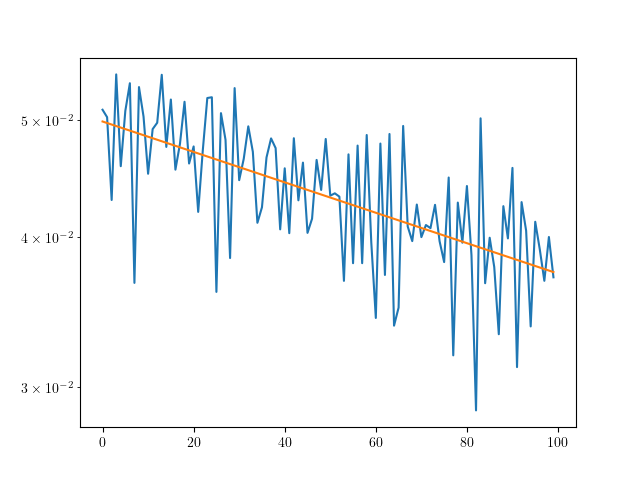

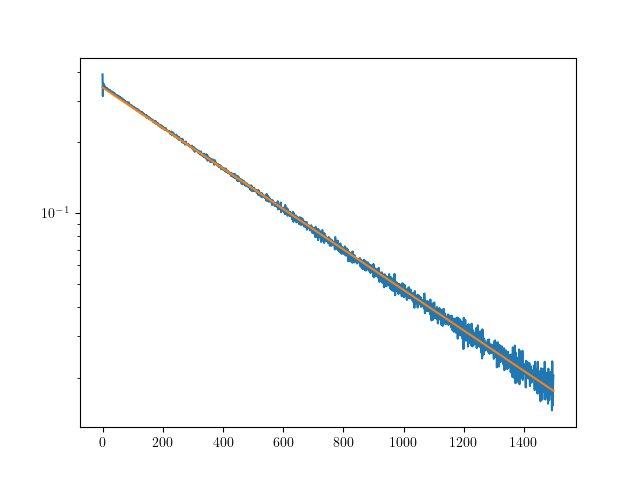

In [10]:
bTa_data.fit_tail(start=900,end=1000)
Al_data.fit_tail(start=500)

In [6]:
bTa_sim=KID_sim(bTa_data,50,200,0.01,1/4,simtime_approx=20)
Al_sim=KID_sim(Al_data,15000,3.1,0.01,1/4,simtime_approx=20)

100%|██████████| 2000/2000 [00:23<00:00, 84.83it/s]


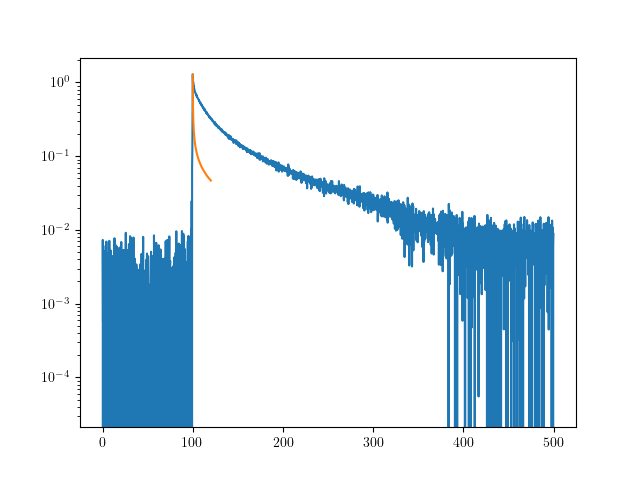

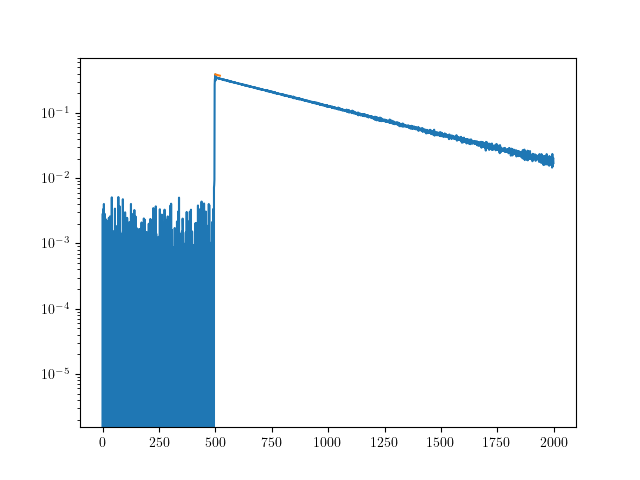

In [7]:
compbTa = sim_data_comp(bTa_data,bTa_sim)
compAl = sim_data_comp(Al_data,Al_sim)
plt.figure()
plt.semilogy(compbTa.t_full,compbTa.phase_data)
plt.semilogy(compbTa.t_sim_aligned,compbTa.phase_sim)
plt.show()
plt.figure()
plt.semilogy(compAl.t_full,compAl.phase_data)
plt.semilogy(compAl.t_sim_aligned,compAl.phase_sim)
plt.show()
